## MEAM5460 Project 3
### Author: Nathaniel Ruhl
### Date: May 2023
#### Main Script: https://github.com/nruhl25/HoveringVehicleDesign/blob/main/proj3/proj3_flap.py

_I worked with Ben Culmer and Nico Black on our approach to the problem and we wrote code indivdually._

### Abstract:

This report presents a method to solve a helicopter trim and reports a preliminary sensitivity analysis of various design components. The results provide helpful information regarding the placement of the center of gravity and the placement of the tail rotor in terms of maximizing control authoritory, reducing blade flapping, and reducing total power.

### 1) Introduction
In this report, I explore the sensitivity of several parameters on the "trim" of a helicopter. These parameters are enumerated 1-4 in the problem assignment above. In other words, we will determine the input controls required to stabilize the helicopter when varying the specified parameters, along with their associated blade-flapping output.

This sensitivity analysis problem is highly coupled, and I tried multiple different techniques to solve the system of coupled equations. The system of equations (A)-(P) in the problem assignment are so highly coupled and non-linear that we must make certain assumptions in order to solve them. Many of these assumptions are realistic and can be related to the flight condition, but before getting into that discussion, it is important take a big picture perspective and to realize the difficulty of including trigonometric functions of unknowns in the system of equations ($\phi$, for example) and how difficult it is to solve them. As a simple example, consider how many times $\sin(\phi)$ passes through zero, and therefore a non-linear equation solver requires a very well-informed initial guess to find the correct solution. 

In my first attempt at this problem, which is located in "proj3\_no\_flap.py", I enforce that there is no longitudinal or lateral flapping, $\beta_{1s}=\beta_{1c}$ (as we did in Project 2), which implies that the rotor is not sustaining x or y moments. Since I did much sensitivity of control inputs when analyzing the results, I decided to re-consider the problem without canceling out flapping. This code is in "proj3\_flap.py", and I will discuss its assumptions, solution methodology, and results in this report.

By making the assumption that $\beta_{1s}=\beta_{1c}=0$ in the first variation, I was able to avoid certain assumptions that are necessary to make in the solution presented in this report (for example, enforcing rotor drag $H$). Nevertheless, the results presented in this report seem to show more realistic trends than with the no-flapping assumption.

### 2) Solution Methodology
__Step 1__  
In order to solve this highly coupled system of equations, I started with the assumption of "level flight," or that $\alpha$ is a small angle and that $T \approx W$ (weight of the helicopter). Therefore, in this problem, I will enfore thrust and assume a value of the ideal power coefficient of the main rotor $\kappa_{mr}=1.15$, which also enforces the rotor power as

$$C_{P_{mr}} = \frac{\sigma c_{d_0}}{8}+\frac{\kappa_{mr}}{\sqrt{2}}C_{T}^{3/2}$$
$$P_{mr} = C_{P_{mr}} * \left(\rho A (\Omega R)^2 \right)$$

where $A$, $R$, $\sigma$ are the main rotor disc area, blade radius, and solidity respectively.

Equating thrust to weight is one of the assumptions that Dr. Leishman makes in his basic trim analysis section, and it works well to kick off the solution process. Using a small angle approximation for $\alpha$, I solved the vehicle attitude angle from Eqn. (A) of the problem assignment:
$$ \alpha = \frac{D_f+H}{T} \qquad \text{Eqn A}^*$$
where $D_f$ is the drag on the fuselage and $H$ is the drag on the rotor. One major drawback of assuming that $\alpha$ is small is that it limits the vehicle attitudes and forward flight velocity that can be accurately considered in the trim analysis. For this reason, I will consider $v_\infty = 60$ ft/sec in this report, which corresponds to $\alpha<2^\circ$ for this specific helicopter.

I choose to enforce both $D_f$ and $H$ as known values, which is likely a realistic scenario if we know the size and shape of the helicopter at this stage of analysis. I approximate $D_f$ by multiplying the experimentally-determined drag coefficient $C_{D,sphere}=0.5$ by the corresponding helicopter fuselage cross sectional area, $A_f$:

$$D_f = C_{D,sphere}A_f*\frac{1}{2} \rho v_\infty^2$$

and I approximate the rotor drag force as the blade section coefficient of drag, $c_{d_0}=0.011$, multiplied by the total blade surface area of the main rotor:

$$H = N_b c_{d_0} R \rho A_b v_\infty^2.$$

While the values of $D_f$, and $H$ specifically, might be slight under-estimates, terms can be added on these equations to make them more realistic. Nevertheless, out of all the unknowns in the system of equations involved in the trim, it seems reasonable to enforce $D_f$ and $H$ as knowns.

Using this information, I define the lift due to the tail empenage, which has a certain spanwise length $L_emp$, chord length $c_{emp}$, and incidence angle with respect to the horizontal body frame $\psi_{emp}$:

$$L_{ht} = -2 \pi (\psi_{emp}-\alpha)L^2_{emp}c_{emp} \rho v_\infty^2.$$

Lastly, now that $\alpha$ is known, we can define the advance ratio, $$\mu = \frac{v_\infty \cos(\alpha)}{\Omega R}$$ and using the known $C_T$, we can define the inflow ratio $\lambda$ from Equation (M).

__Step 2__  
The second step in the solution procedure requires a "fixed point iteration" on $Y$. I start with an initial guess of $Y=100$, solve the rest of the trim using $Y=100$, and then once I have solved the flapping angles $\beta_0, \beta_{1c}, and \beta_{1s}$, I re-calculate $Y=fnc(\beta_0, \beta_{1c}, \beta_{1s})$ from Equation (I) and use that to check for convergence. Overall this method is very well-behaved an only requires about 20 iterations to converge.

__Step 2a__  
Using a small angle approximation for $\phi$, the assumption that $T=W$, the value of $Y$ defined entering the last iteration of the loop, and the assumption that the fuselage force is $Y_f=W\sin(\phi)\approx W \phi$, we can solve the lateral and vertical force balances of Equations (B) and (C). Using our assumptions and what we have determined so far, we arrive at a non-linear system of 2 equations and 2 unknowns ($\phi$ and $T_{tr}$) that ``fsolve`` can easily handle:
$$T \phi + Y + Y_f + T_{tr} - L_{ht} \phi \qquad \text{Eqn B}^*$$
$$T\cos(\alpha) - Y \phi + H\sin(\alpha)-L_{ht}-W-T_{tr}(\phi-\psi_{tr}) \qquad \text{Eqn C}^*$$
where I have introduced $\psi_{tr}$ as the tail rotor inclination angle. It should be noted that I did not use the small angle approximations for $\alpha$ in these equations since it is already known. I am not sure whether it is more internally consistent to make the small angle approximation throughout the full system of equations, or whether you should use the trig functions once $\alpha$ is already defined. Either way, the same solution procedure applies.

__Step 2b__  
The next part of step 2 is to solve a large, non-linear system of equations. While I learned throughout this project to avoid blindly giving ``fsolve`` large systems of equations, this one is well-formulated and at most quadratic in unknowns ($\beta_0$, $\beta_{1c}$, and $\beta_{1s}$). The system of 9 equations and 9 unknowns is 

$$\text{Equations: D, E, F, G, H, J, N, O, P}$$
$$\text{Unknowns: }\mathbf{x}=[\theta_0, \theta_{1c}, \theta_{1s}, \beta_0, \beta_{1c}, \beta_{1s}, M_{xf}, M_{yf}, M_{zf}]^T$$

where I make use of Equations (K) and (L) to write $C_{M_x}$ and $C_{M_y}$, and hence $M_{x_r}$ and $M_{y_r}$ in terms of the standard unknowns. The moments are related to their coefficients by
$$M = C_M \rho R (\Omega R)^2.$$

Additionally, we know that the rotor moment $M_{z_r}$ is directly related to the rotor coefficient of torque as
$$M_{z_r}=-C_Q \rho A R (\Omega R)^2$$.

Overall, this system of equations works better than my previous attempts, but it is not perfect. Equations (H) and (J) for $C_H$ and $C_Q$ are most difficult to converge, which are the equations quadratic in their unknowns. The other equations converge reliably. Since I noted that Equation (J) for $C_Q$ would usually converge to zeros within 1e-4 and $C_H$ would converge within 1e-5. I printed an error message to the console when the equation either of them converged to within less than 1e-4. This is what happened when I say that "results did not converge" in the solution section. I am not exactly sure what this tolerance on $C_Q$ corresponds to in terms of the flapping angles, but some of the plots in the results section give an idea of this error when the system does not converge.

For the reasons stated above, if I had time to re-do this problem, I would use $C_Q$ (or $C_H$) as the "outer loop" (replacing the role that $C_Y$ plays in the current algorithm), and put $C_Y$ (Eqn I) in the system of equations, since it is much less non-linear. This may lead to larger run-times and more iterations within a hard-coded for-loop, and it might be beneficial to make the fixed-point iteration more robust, but I would rather this than not being able to understand exactly why the semi-blackbox of ``fsolve`` is having difficulty solving the equation. Based on operating conditions  and/or what we know about the helicopter, we could choose to impose either $C_Q$ or $C_H$. (I actually did an "outer loop" with $C_H$ in my solution with no flapping in proj3_no_flap.py, which is an example of this, but there was no flapping in that solution and it was extremely well-behaved).

After the system is solved, we can use Equation (I) to re-calculate $C_Y$ (and $Y$), which we then compare to the pervious iteration, and define convergence when an absolute tolerance of 1e-9 has been achieved between $Y$ and $Y_{last}$.

__Step 3__  
The final step is to solve the tail rotor trim. Since we have a converged value of $T_{tr}$ from step 2a, we can immediately define the coefficient of torque of the tail rotor as

$$C_{T_{tr}} = \frac{T_{tr}}{\rho A_{tr}(\Omega_{tr} R_{tr})^2}.$$

For the tail rotor, we have $\theta_{tw}=0^\circ$, no cyclicl inputs, $\theta_{1c}=\theta_{1s}=0$, and I assume that we are controlling it to cancel out flapping and coning $\beta_0=\beta_{1c}=\beta_{1s}=0$. The trim can thus be written as a system of 2 equations and 2 unknowns ($\alpha_{tr}$ and $\theta_0$). Since $\lambda_{tr}=fnc(\alpha_{tr}, \theta_0)$ and $\mu_{tr}=fnc(\alpha)$ are unique values, we can simplify the trim equations and write the system as

$$(1+\mu^2)\theta_0-\frac{4}{3}\lambda_{tr} = 0$$

$$\frac{8}{3}\mu \theta_0 - 2 \mu \lambda_{tr} = 0.$$

Lastly, we can assume that the tail rotor has a value of $\kappa_{tr}=1.25$ (less efficient than the main rotor because of interference), the same section drag coefficient as the main rotor, $c_{d_0}=0.011$, and define a solidity $\sigma_{tr}$ based on the parameters given in the problem statement. This let's us define the power of the tail rotor as
$$C_{P_{tr}} = \frac{\sigma_{tr}c_{d_0}}{8}+\frac{\kappa_{tr}}{\sqrt{2}}C_{T_{tr}}^{3/2}$$
$$P_{tr} = C_{P_{tr}} * \left(\rho A_{tr}R_{tr}(\Omega_{tr}R_{tr})^2 \right).$$

The total power required to trim out the system is thus:

$$P = P_{mr}+P_{tr}.$$

### 3) Baseline Helicopter Specifications 

The dimensions of the helicopter given in the project assignment are defined as global variables in "proj3_flap.py" in lines 8-41. In addition to what is given in the project, I defined the chord length of the empenage as $c_{emp}=2$ ft and the main rotor twist as $\theta_{tw}=-8^\circ$. Inspired by the UH-60 which has a "dry weight" of 14,000 lbf, I will consider a "weight weight" of 20,000 lbf in the results.

As stated previously, I ran the analysis below for $v_\infty=60$ ft/sec. In the results section, I vary the 10 parameters defined in the list below. The dimensions are similar to the dimensions of a UH-60, which I found on-line. In the list, I define the baseline configuration which is followed in the parametric sweeps (other than the parameter being varied):

- Longitudinal center of gravity, $x_{cg}=0$ ft
- Lateral center of gravity, $y_{cg}=0$ ft
- Vertical center of gravity, $h_{cg}=-3$ ft
- Longitudinal tail empenage position, $x_{ht}=15$ ft
- Spanwise size of the tail empenage, $L_{emp}=2$ ft
- Incidence angle of tail empenage, $\psi_{emp}=0^\circ$
- Longitudinal position of the tail rotor, $x_{tr}=45$ ft
- Vertical position of the tail rotor, $h_{tr}=3$ ft
- Inclination angle of tail rotor, $\psi_{tr}=0^\circ$
- Non-dimensional blade flapping fequency, $\nu_\beta = 1$


### 4) Results
Below, I will show plots for each of the sensitivities enumerated 1-4 in the project assignment. I will provide some analysis at the end of each subsection, and bigger picture conculsioins in the Discussion section.

In [5]:
import plotter # plotting functions
import importlib
importlib.reload(plotter)
from plotter import *
import warnings
warnings.filterwarnings('ignore') # for the purpouse of plotting in the notebook

__4.1) Center Of Gravity Placement Range and Sensitivity__

__Longitudinal Center of Gravity__

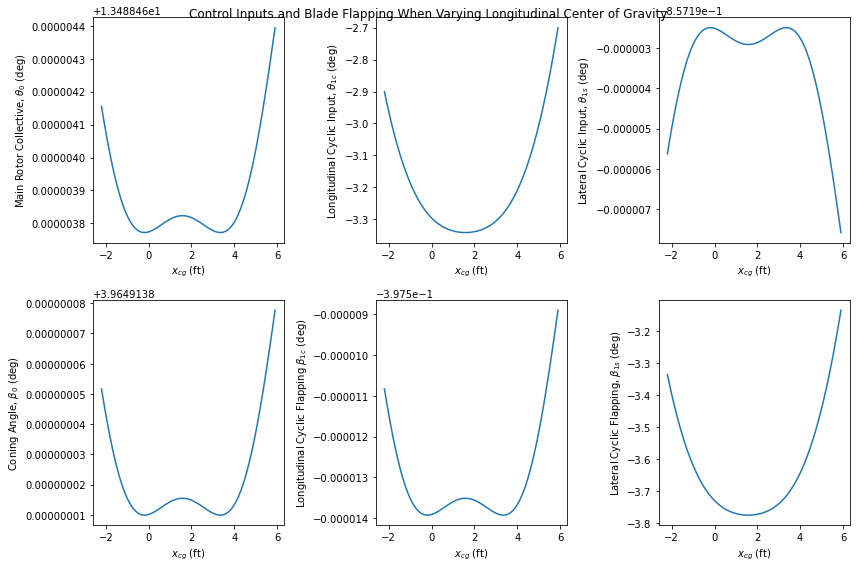

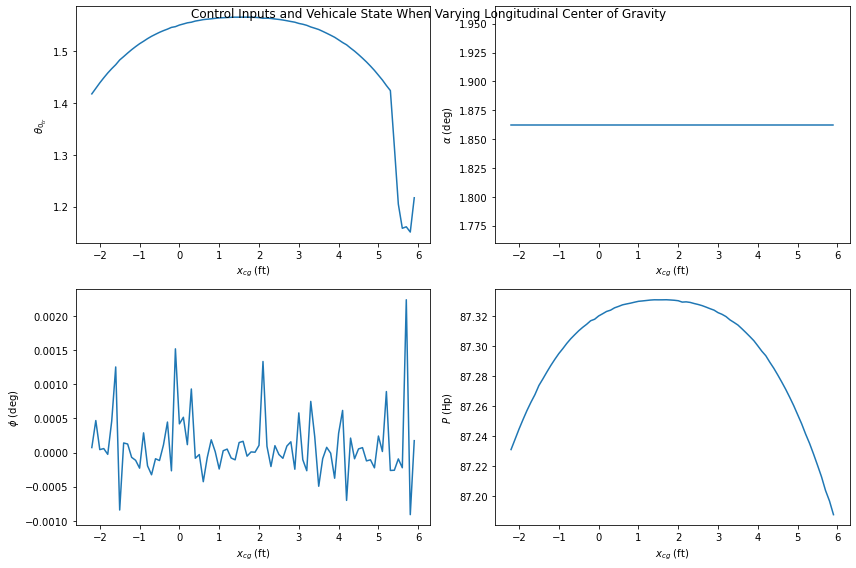

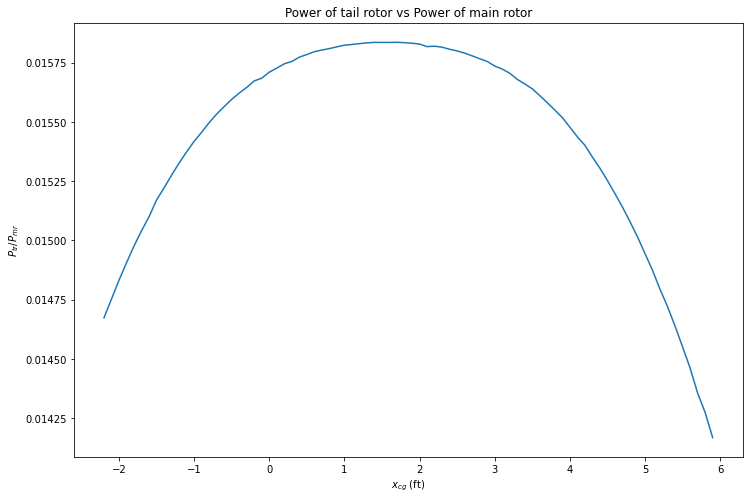

In [35]:
vary_xcg()

__Lateral Center Of Gravity__

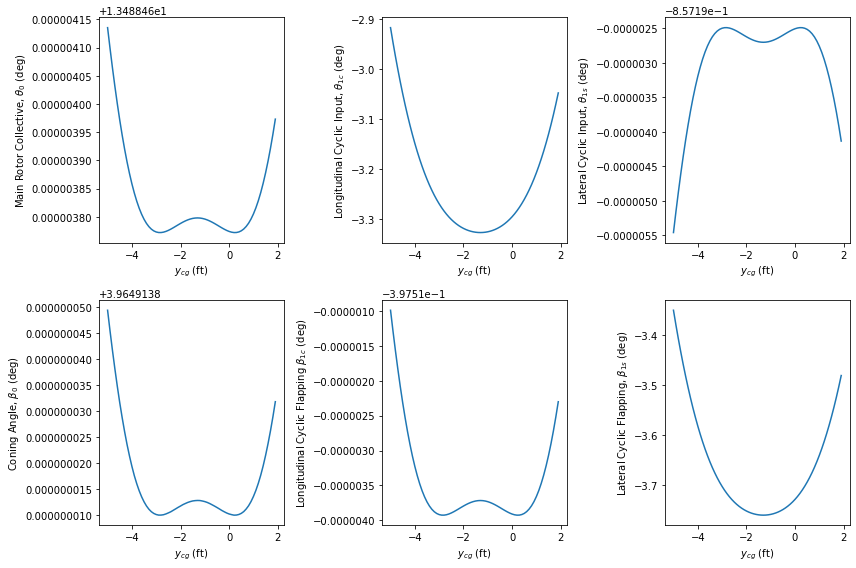

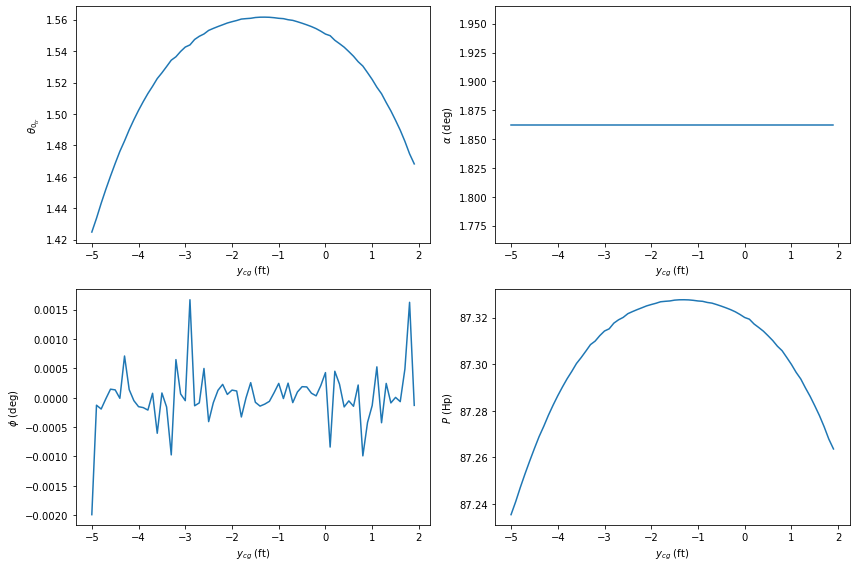

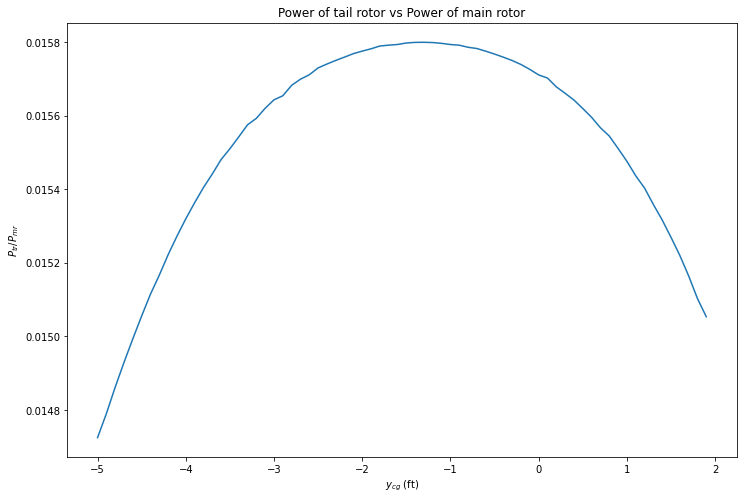

In [36]:
vary_ycg()

__Vertical Center of Gravity__

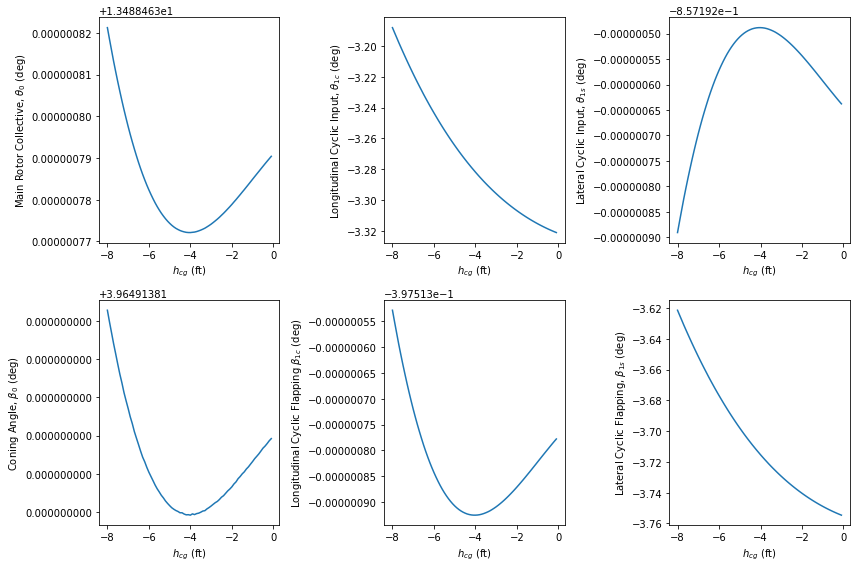

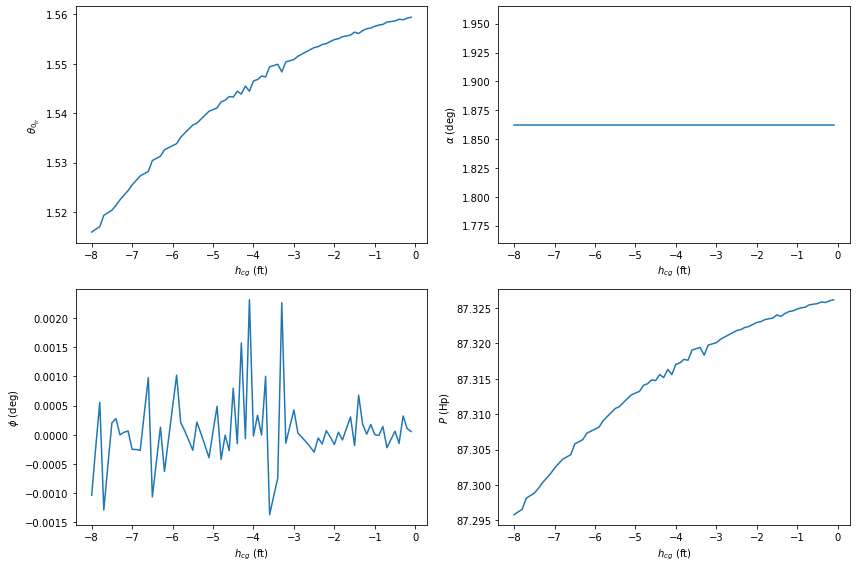

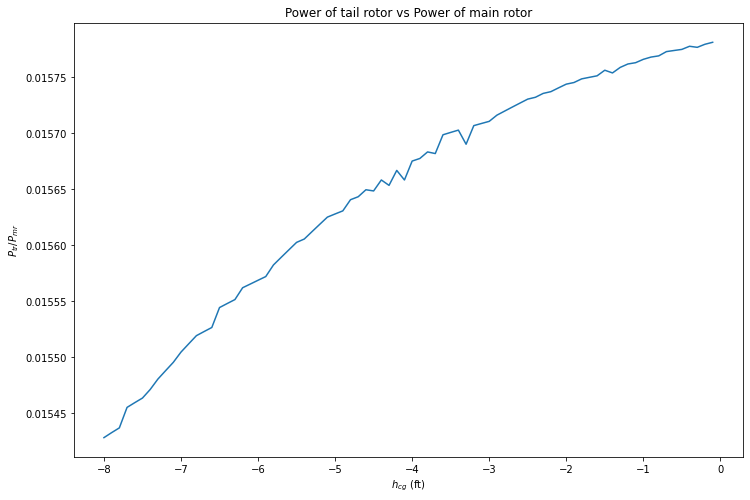

In [37]:
vary_hcg()

The plots for $x_{cg}$ and $y_{cg}$ look very similar. The "plateau" regions in the plots show where the controls and flapping outputs are least sensitive to the center of gravity, and thus most "stable". In this analysis, I define stability based on the plateau behavior, not based on the magnitude of the values, although the plots show that the group of $\theta_{1c}$ and $\beta_{1s}$ vary on a much larger scale than $\theta_{1s}$ and $\beta_{1c}$. These plateau regions approximately overlap for all inputs and all flapping angles, and can be identified as

$$0 \lesssim x_{cg} \lesssim 4 \text{ ft}$$
$$-3 \lesssim y_{cg} \lesssim 1 \text{ ft}.$$

It can be seen that the tail rotor draws more power in these more stable configurations (recall that the main rotor power is constant). Therefore, there is a trade-of between stability and power when choosing the center of gravity position. 

The results of varying $h_{cg}$ look very different than those of $x_{cg}$ and $y_{cg}$. We see that $\theta_{1c}$ and $\beta_{1s}$ are never reach a minimum sensitivity. For the reasonable range of $h_{cg}$ shown in the above plots, there will always be a tradeoff between $\beta_{1s}$ stability and required power. On the other hand, we can define an approximate range of stability based on $\theta_0$ and $\beta_0$, and $\theta_{1s}$ and $\beta_{1c}$ as
$$-6 \lesssim h_{cg} \lesssim -2.$$

__4.2) Varying Tail Empenage Parameters__

This group of plots below is not very inciteful. I am not sure if I made an error, or it is possible that these parameters are play such a minor role in the overall balance that my solution method is not accurate enough to resolve the effects.

__Varying Tail Empenage Span__

Originally, I was getting results that showed an increase in $\beta_{1c}$ stability and a decrease in required power as $L_{emp}$ increased, but I am not able to-remake this plot. Near the maximum size of 10 feet, I started to see diminishing returns of increasing $L_{emp}$. For reference, I will show the plot below, but not include these conclusions in my recommendations.

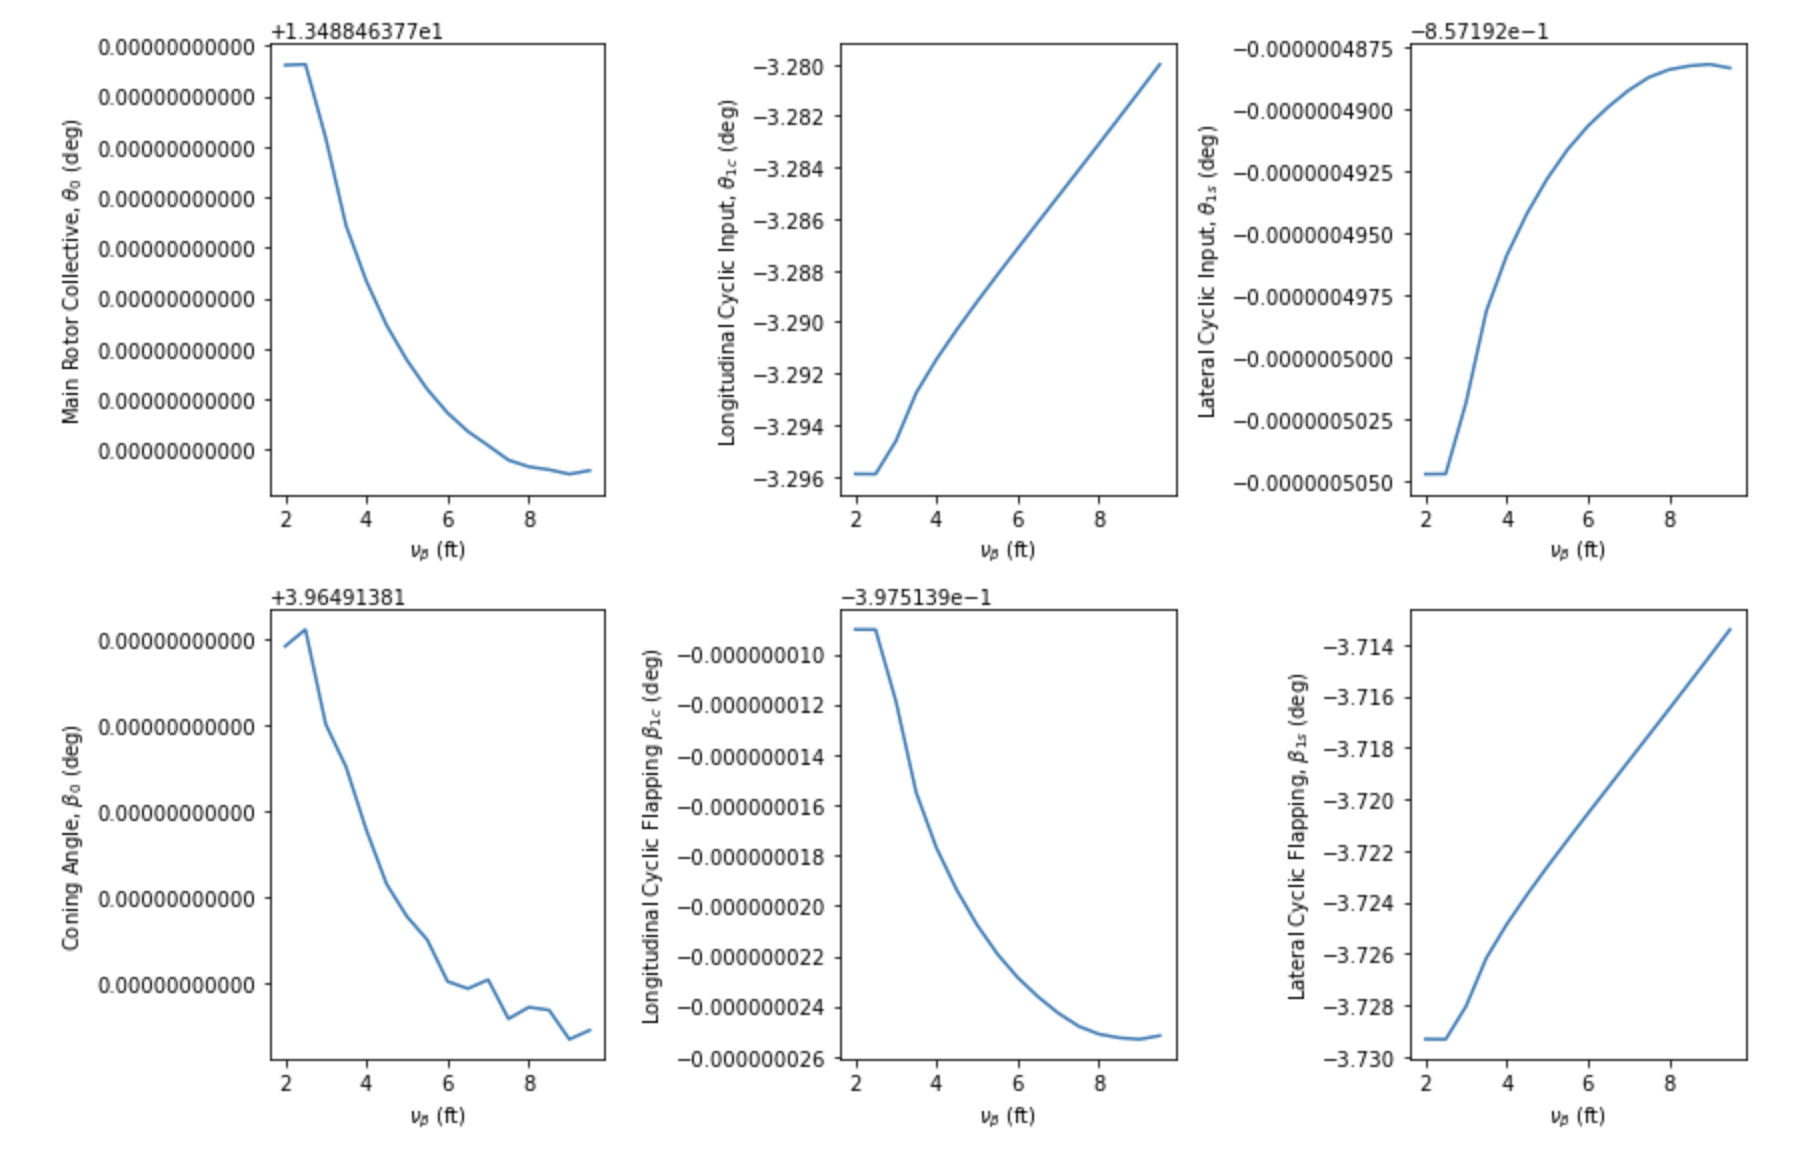

In [11]:
from IPython.display import Image
Image(filename='L_emp_fig1.png',width=600)

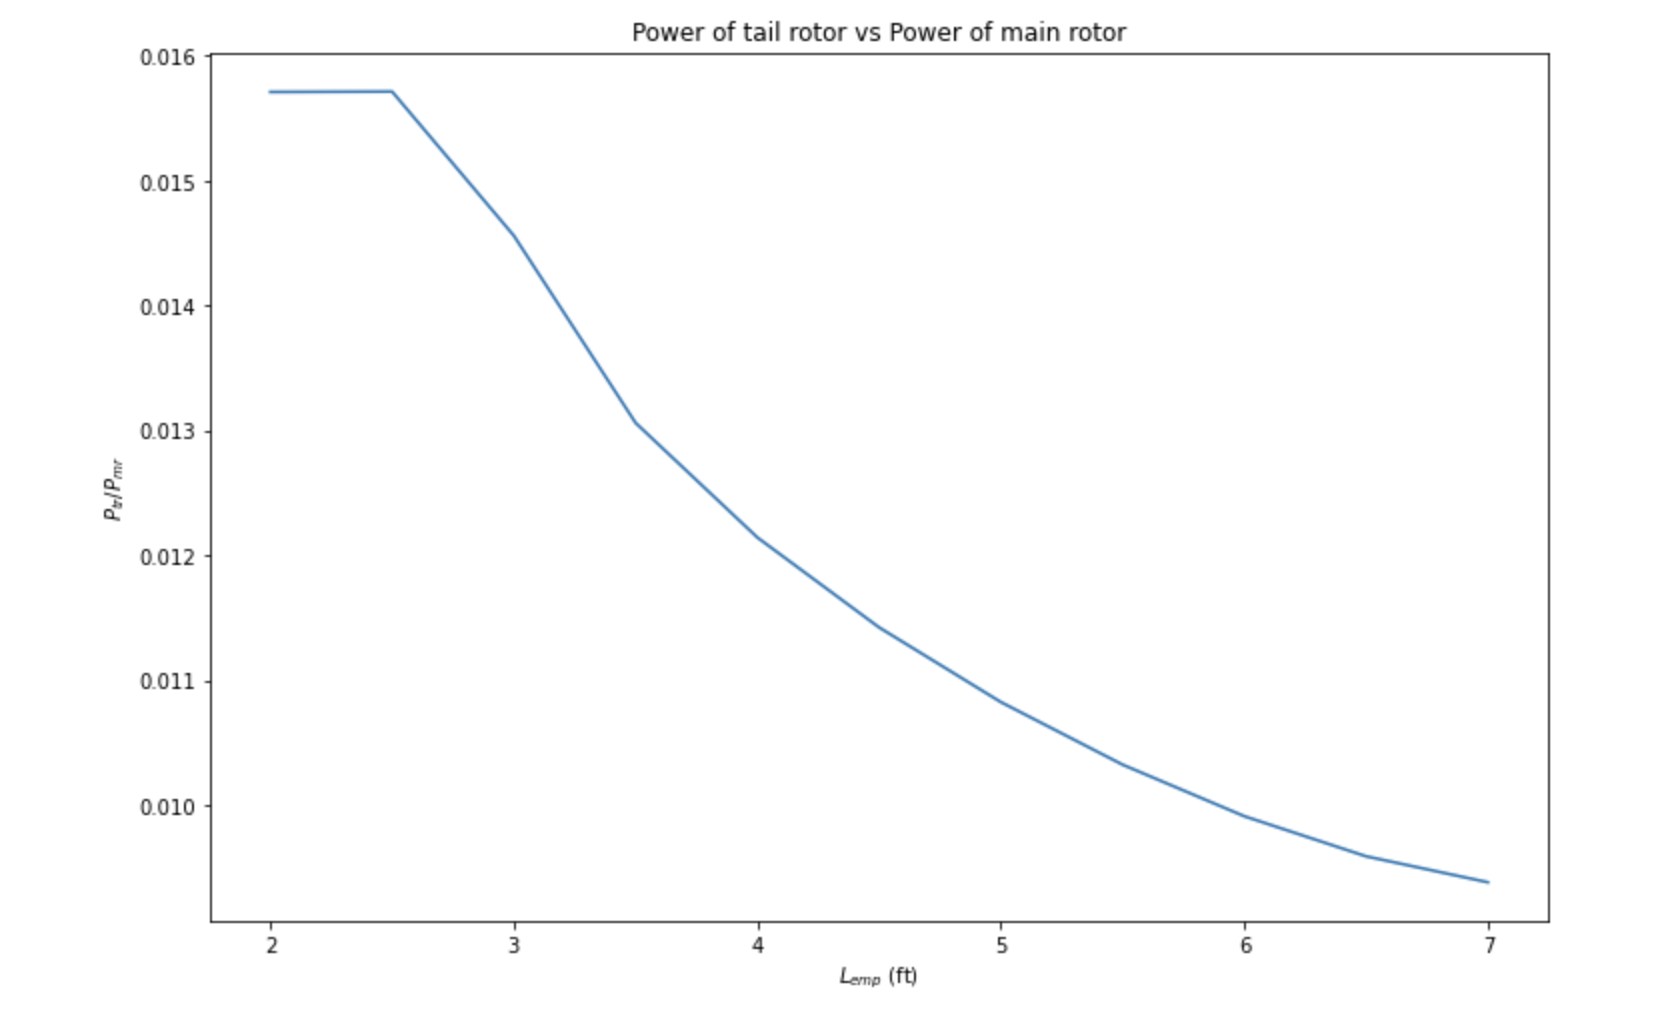

In [12]:
Image(filename='L_emp_fig2.png',width=600)

__Tail Empenage Inclination Angle__

The results seem to show slight trends in spite of numerical instabilities. While sensitivity (slope of these plots) remains constant, the magnitude of $\beta_{1c}$ flapping decreases and $\beta_{1s}$ increases with increasing $\psi_{emp}$.

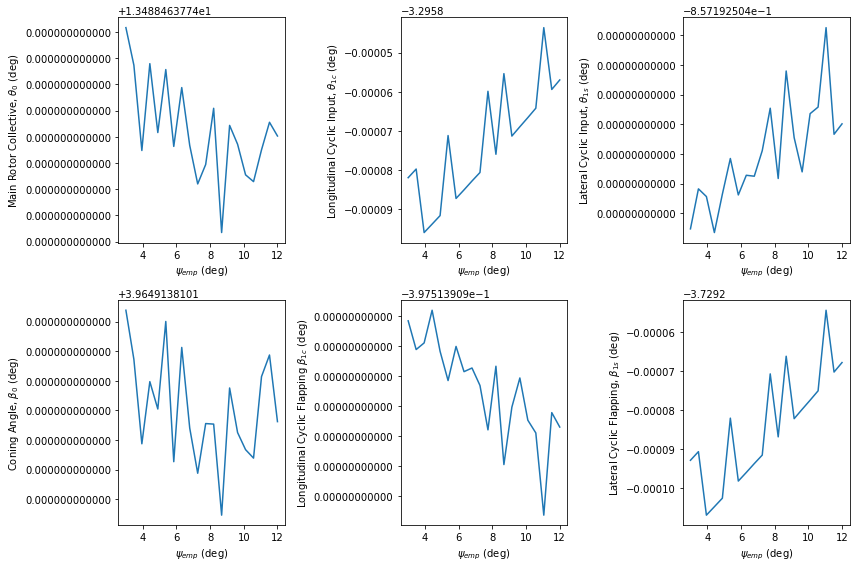

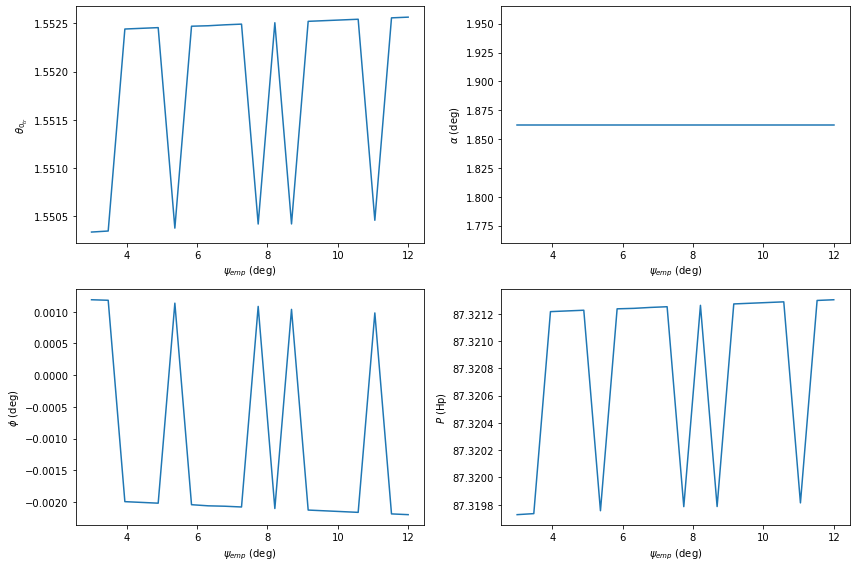

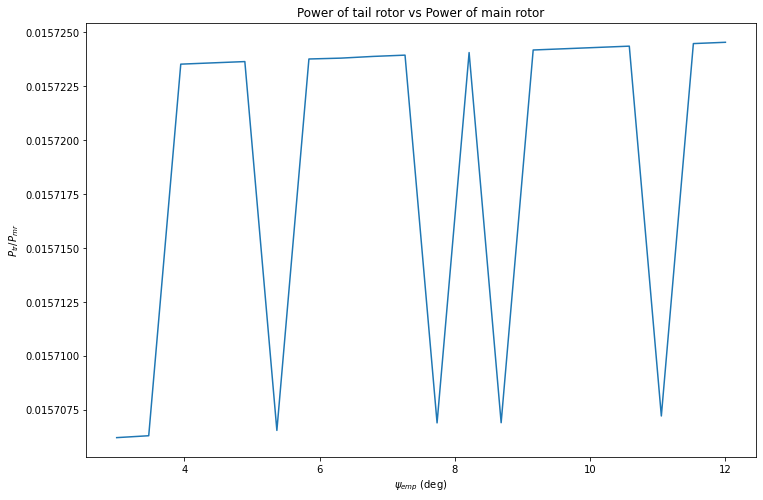

In [39]:
vary_psi_emp()

__Longitudinal Position of Tail Empenage__

Similar to the plots above, these plots are ridden with numerical error. The plots could potentially indicate a decrease in $\beta_{1s}$ with $x_{ht}$.

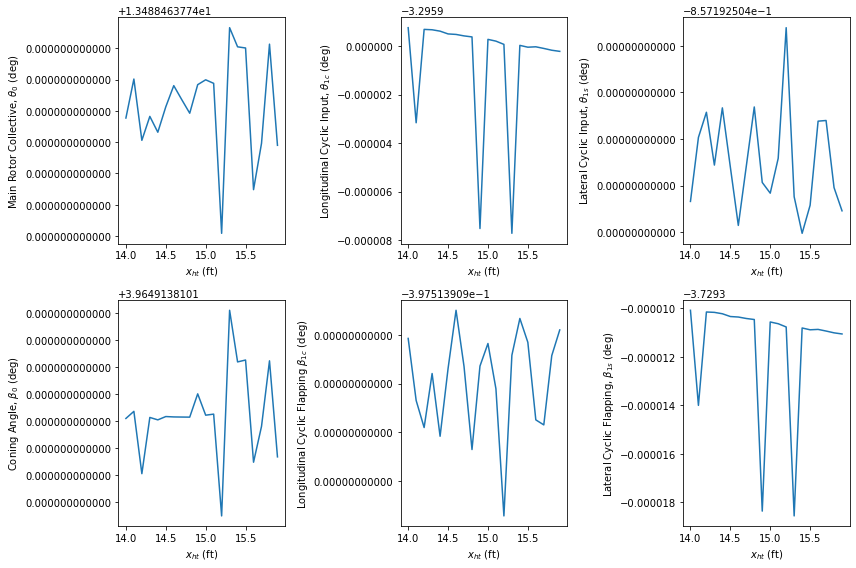

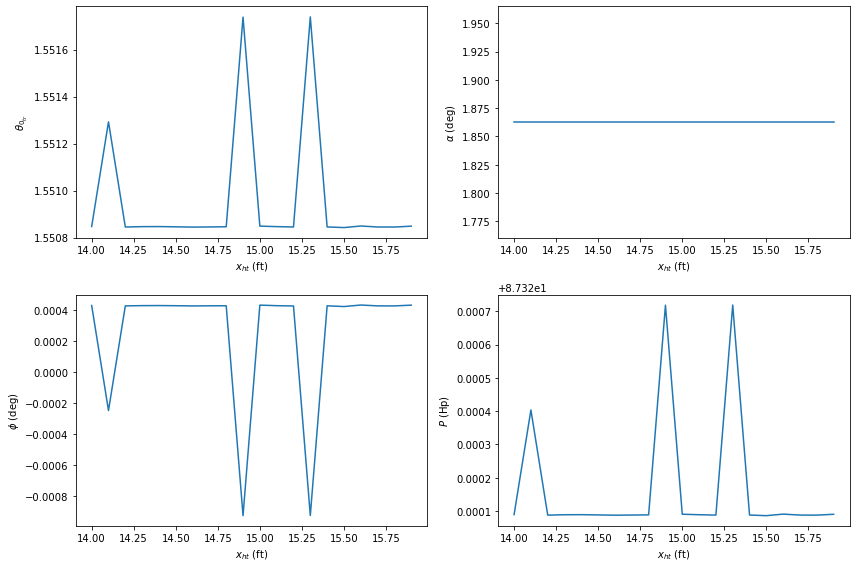

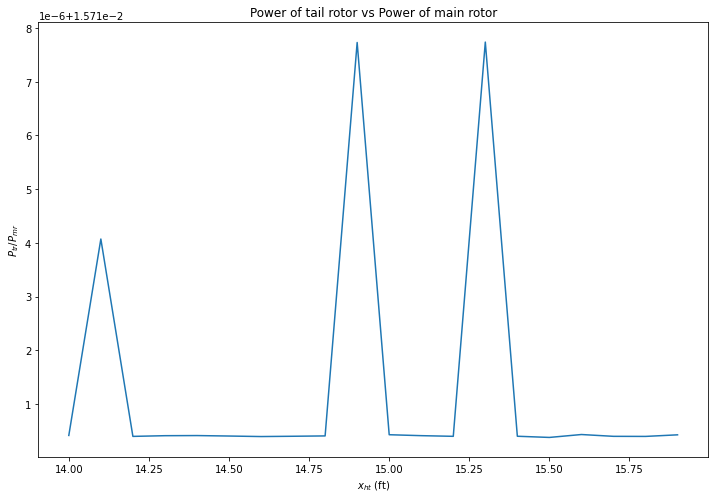

In [40]:
vary_xht()

__4.3) Varying Tail Rotor Parameters__

__Longitudinal Position of Tail Rotor__

The plot below clearly shows ranges of $x_{tr}$ wich are most stable. It is interesting that the ranges of best stability are slightly different for $\beta_{1c}$ are slightly different than the range for $\beta_{1s}$. For stability of $\beta_{1c}$ and $\beta_0$, $43 < x_{tr} < 47$ ft is best, but for stability of $\beta_{1s}$, $41 \lesssim x_{tr} \lesssim 45$ ft is best. Considering the magnitude of $\beta_{1s}$, it may be better to choose the range that stabilizes $\beta_{1s}$, although power is slightly larger in this range.

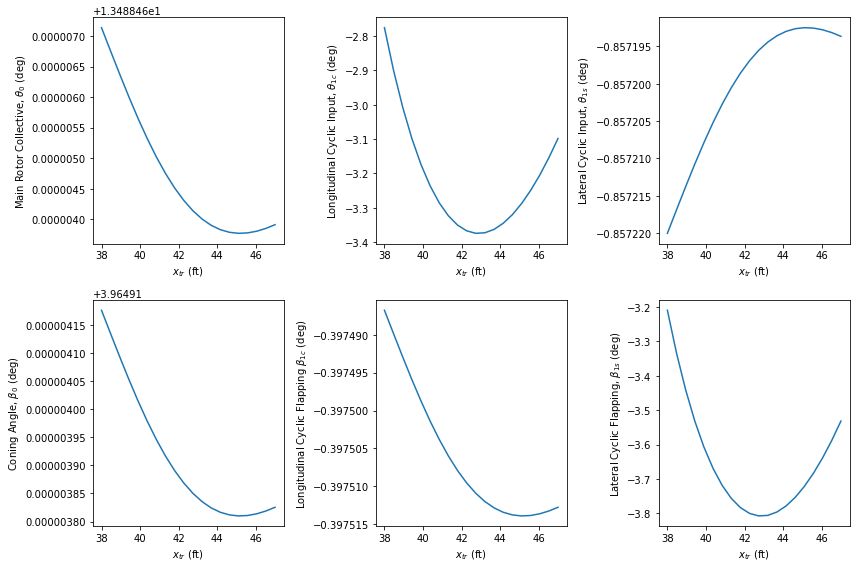

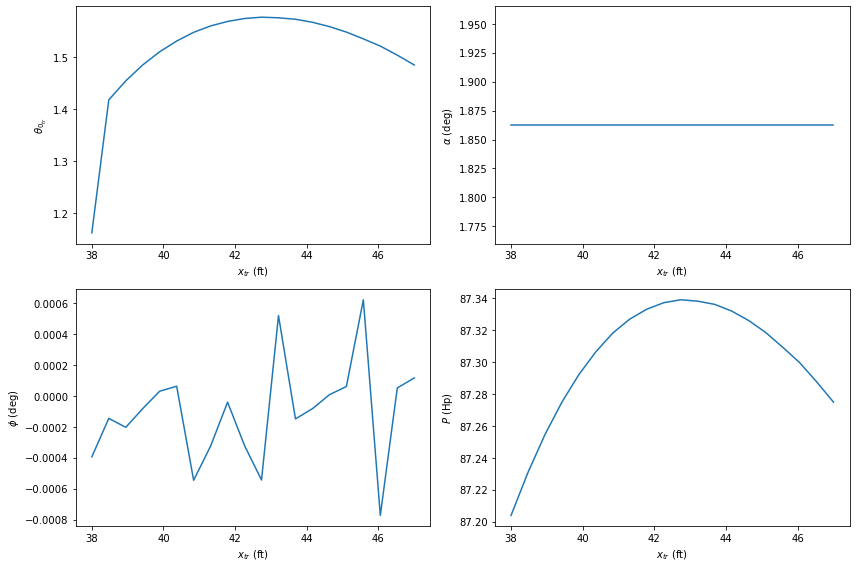

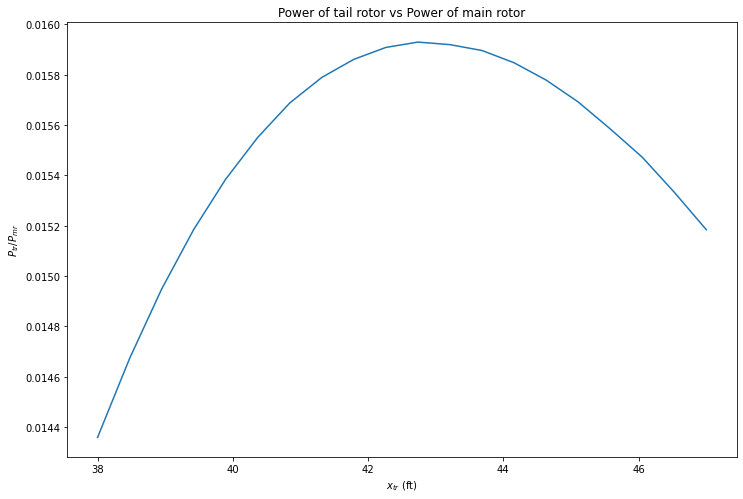

In [41]:
vary_xtr()

__Vertical Position of Tail Rotor__

The plots below show that $3 \lesssim h_{tr} \lesssim 5$ ft is best for the stability of $\beta_{1c}$, while $\beta_{1s}$ becomes more sensitive with increasing $h_{tr}$. Power always decreases with increasing $h_{tr}$.

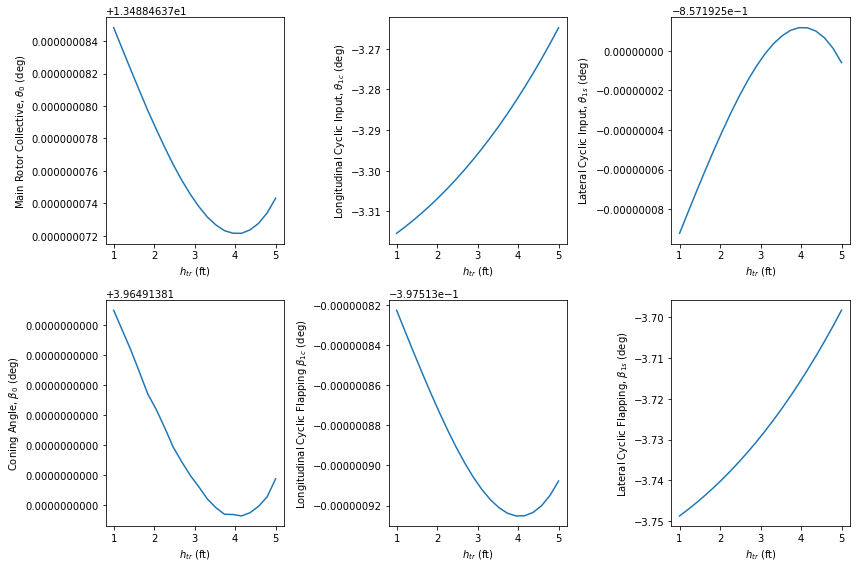

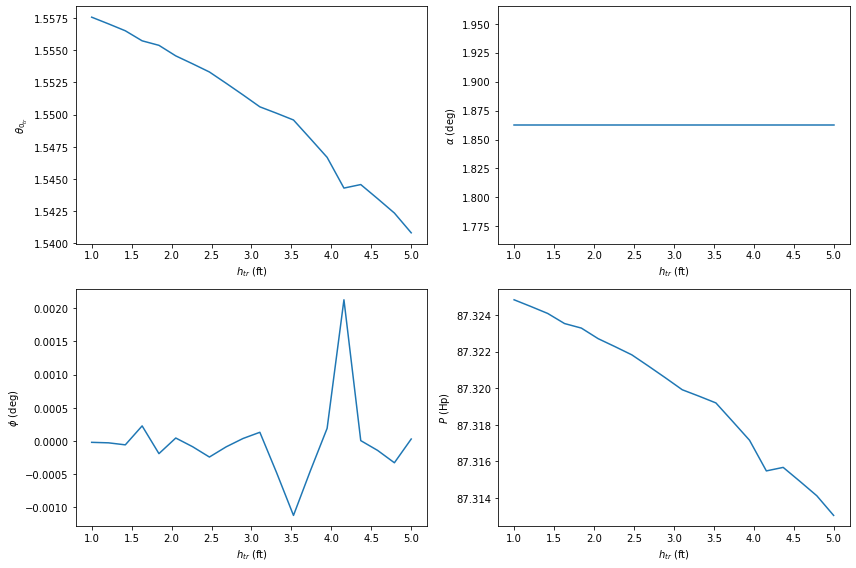

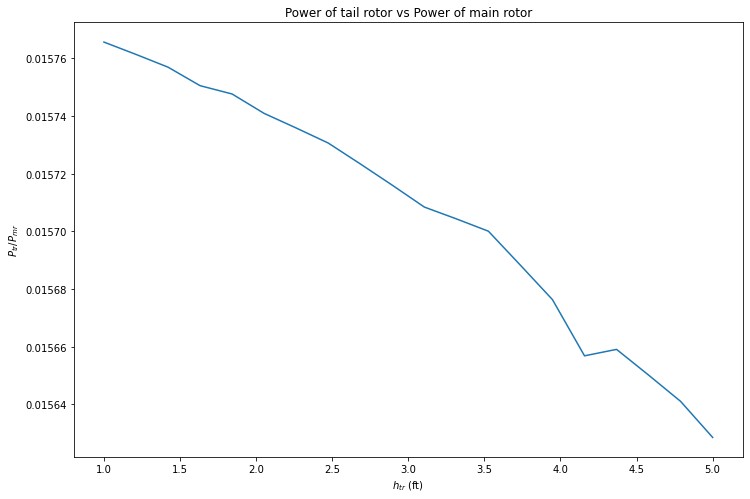

In [42]:
vary_htr()

__Incidence Angle__

The solution did not converge when changing incidence angle, so I will not show the plot.

__4.4) Blade Flapping Frequency Sensitivity__  

I expect that there were some convergence issues with these plots. Overall, it seems like sensitivity remains fairly constant with flapping frequency. It is also interesting to see that while coning angle decreases with increasing $\nu_\beta$, the magnitude of $\beta_{1s}$ increases. Power seems to increase with $\nu_\beta$

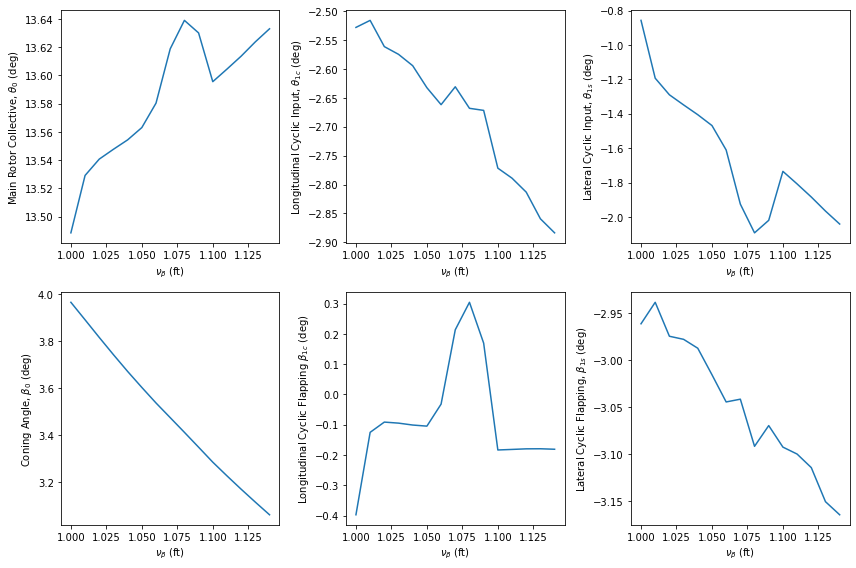

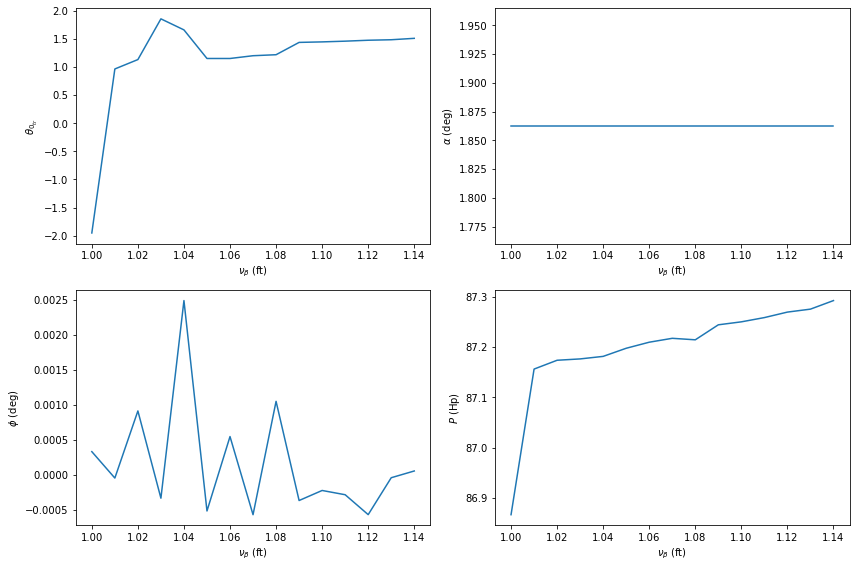

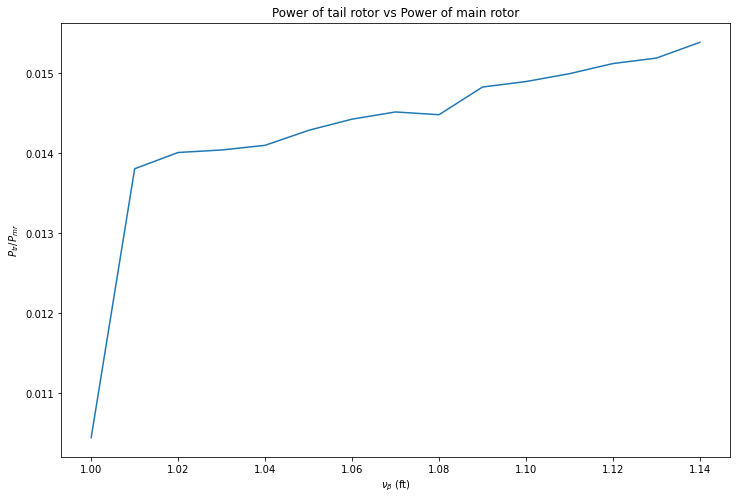

In [8]:
vary_nu_beta()

## 5) Additional Discussion

__Dicusion of Vehicle Attitude Angles and Improving Trim Solution Algorithm__  
In the plots above, we see that $\alpha=1.86^\circ$ is always contant for a given forward flight velocity, and does not show any sensitivity to the changing parameters. This is likely because of my assumption that $T=W$ is constant and how I uncoupled the problem, but I am not 100% sure how innacurate this is in real life. It makes sense that, based on my assumption that the rotor is generating a constant thrust, the helicopter/rotor would need to be tilted a constant amount for a specificed forward thrust, no matter what the other parameters are. 

Based on the plots, it doesn't look the solution for $\phi$ provides much information, as the solution is always noisy around zero. If I were to re-do this trim, I would consider the results under the assumption that $\phi=0^\circ.$ This assumption would greatly simplify solving the lateral and vertical force balances in Equations (B) and (C), as the thrust of the tail rotor would simply be $T_{tr}=-Y$, although I am not sure if this is a realistic assumption. Especially with the iteration over $Y$, the solution for $\phi$ seems to be one of the main issues in my solution procedure.

__Discussion of Other Sensitivities__  
Although it not shown in the plots, the forces and moments change significantly when varying the parameters. Therefore, there is extra sensitivity analysis that needs to be done when consider the materials of the different structures bearing the aerodynamic loads and moments. Thus, the force and moments resulting from the trim are more pertinent to materials/manufacturing design choices, while the sensitivty analysis of the controls above assumes that the helicopter can withstand the necessary loads.

__Tail Rotor Trim Validation__  
In the flight condition with $v_\infty=60$ ft/sec, our calculations show that $P_{tr}/P_{mr} \approx 1.5$. In Dr. Leishman's textbook, he says that the ratio is usually around 3-5% for normal operating conditions, and up to 20% at the edges of the "flight envelope." Since a UH-60 can reach a maximum speed of around 230 m/s, and since our analysis does not consider any transmission inefficies, these power ratios are a good validation of the tail rotor trim results and required thrust for force/moment balance.

## 6) Conclusions and Recommendations

In this section, I will give a concise overview of the main results in this paper and my reccomendations for a preliminary design. Since I use the small angle approximation for $\alpha$, my trim is most applicable for the lower-flight velocities, and in this report, I restricted my attention to $v_\infty=60$ ft/sec.

As a result of numerical error in my solution algorithm, my results might not be resolved enough to determine the effect of changing parameters related to the tail empenage. For this reason, I do not yet have recommendations for the tail empenage size, location, or incidence angle. Furthermore, ther results do not resolve the effect of varying $\nu_\beta$ extreamly well, but overall, power seems to increase with $\nu_\beta$. 

For the flight condition of $v_\infty = 60$ ft/sec, the results presented in this paper indicate the best locations of the CG and Tail Rotor to be approximately:

__Approximate CG range for best stability__:
$$0 \lesssim x_{cg} \lesssim 4 \text{ ft}$$
$$-3 \lesssim y_{cg} \lesssim 1 \text{ ft}$$
$$-6 \lesssim h_{cg} \lesssim -2 \text{ ft}$$

__Approximate Tail Rotor position for best stability__:
$$41 \lesssim x_{tr} \lesssim 45 \text{ ft}$$
$$3 \lesssim h_{tr} \lesssim 5 \text{ ft}$$
- Power decreases monotonically with increasing $h_{tr}$


We've also seen that the range of largest "stability" can be slightly different for $\beta_0$, $\beta_{1c}$, $\beta_{1s}$, and $P$, and the choice of the range will depend on what is most important for the vehicle's operational state. Often-times, there is a direct trade-off between stability and power. 
